<a href="https://colab.research.google.com/github/BiancaStadl/Bachelorarbeit/blob/main/02_same_approach_as_03_huggingface_distil_multi_bert_ohne_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Siehe https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a  

Punkt 2.2.3




huggingface
https://huggingface.co/distilbert-base-multilingual-cased


look at that! https://huggingface.co/transformers/model_doc/distilbert.html

https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
mit:

hier sehr viel von https://github.com/RayWilliam46/FineTune-DistilBERT/blob/main/notebooks/train_balanced.ipynb (batchencode und model building)


freeze unfreeze siehe:
* https://www.tensorflow.org/guide/keras/transfer_learning?hl=en#the_typical_transfer-learning_workflow
* https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

https://huggingface.co/docs/transformers/task_summary#sequence-classification

https://huggingface.co/distilbert-base-multilingual-cased

https://www.tensorflow.org/guide/keras/transfer_learning?hl=en#the_typical_transfer-learning_workflow 

general tutorial: https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

German pre-trained embeddings:
* Distilbert -> cite!! https://huggingface.co/distilbert-base-multilingual-cased 

https://github.com/huggingface/transformers

https://medium.com/@yashvardhanvs/classification-using-pre-trained-bert-model-transfer-learning-2d50f404ed4c

"As we will see, the Hugging Face Transformers library makes transfer learning very approachable, as our general workflow can be divided into four main stages:

    Tokenizing Text
    Defining a Model Architecture
    Training Classification Layer Weights
    Fine-tuning DistilBERT and Training All Weights"

    https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

Citation: Using GPU in colab and Tensorflow: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.7905427249997956
GPU (s):
0.03716280599928723
GPU speedup over CPU: 75x


In [3]:

import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from keras import losses
from tensorflow import keras 
from keras import optimizers 
from keras import metrics 

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing


In [4]:
!pip install transformers 
from transformers import DistilBertTokenizerFast
#distilbert-base-german-cased,distilbert-base-multilingual-cased

# Instantiate DistilBERT tokenizer...Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')
##Achtung: but the distilbert-base-multilingual-cased model throws an exception during training -> siehe https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed
#direkt von https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379

documentation
https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__

In [5]:
#von direkt https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 60


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=32, max_length=60):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)
    
    


In [6]:
max_length = 60

In [7]:
url = "https://github.com/uds-lsv/GermEval-2018-Data/archive/master.zip"

dataset = tf.keras.utils.get_file("GermEval-2018-Data-master.zip", url, 
                                   extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'GermEval-2018-Data-master')


In [8]:
#os.listdir(dataset_dir)

In [9]:
training_file = os.path.join(dataset_dir, 'germeval2018.training.txt')
#with open(training_file) as f:
 # print(f.read())

#print()

testing_file = os.path.join(dataset_dir, 'germeval2018.test.txt')


In [10]:
def remove_clutter(string):
   string = re.sub("@[^\s]+"," ",string)
   string = re.sub("#[^\s]+"," ", string)
   string = re.sub("\u00a9"," ", string)
   string = re.sub("\u00ae"," ", string)
   string = re.sub("[\u2000-\u3300]"," ", string)
   string = re.sub("\ud83c[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83d[\ud000-\udfff]"," ", string)
   string = re.sub("\ud83e[\ud000-\udfff]"," ", string)
   string = re.sub("😜", " ",string)
   string = re.sub("🍫", " ",string)
   string = re.sub("😁", " ",string)
   string = re.sub("🐖", " ",string)
   string = re.sub("😡", " ",string)
   string = re.sub("😇", " ",string)
   string = re.sub("😬", " ",string)
   string = re.sub("😃", " ",string)
   string = re.sub("😂", " ",string)
   string = re.sub("💙", " ",string)  
   string = re.sub("😛", " ",string)
   string = re.sub("🙏", " ",string)
   string = re.sub("👍", " ",string)
   string = re.sub("🖕", " ",string)
   string = re.sub("😉", " ",string)
   string = re.sub("💩", " ",string)
   string = re.sub("🤢", " ",string)
   string = re.sub("👏", " ",string)
   string = re.sub("😨", " ",string)
   string = re.sub("🤣", " ",string)
   string = re.sub("🤡", " ",string)
   string = re.sub("😈", " ",string)
   string = re.sub("💃🏽", " ",string)
   string = re.sub("👹", " ",string)
   string = re.sub("🤘", " ",string)
   string = re.sub("😱", " ",string)
   string = re.sub("🤔", " ",string) 
   string = re.sub("🌈", " ",string) 
   string = re.sub("💕", " ",string) 
   string = re.sub("👩‍❤️‍👩", " ",string) 
   string = re.sub("😍", " ",string) 
   string = re.sub("👆", " ",string) 
   string = re.sub("😖", " ",string) 
   string = re.sub("👇", " ",string) 
   string = re.sub("🔥", " ",string) 
   string = re.sub("😘", " ",string) 
   string = re.sub("🎉", " ",string) 
   string = re.sub("🤬", " ",string) 
   string = re.sub("👊", " ",string)
   string = re.sub("🇩🇪", " ",string)  
   string = re.sub("💔", " ",string)
   string = re.sub("🙈", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🐟", " ",string)
   string = re.sub("🛶", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😓", " ",string)
   string = re.sub("😳", " ",string)
   string = re.sub("🚀", " ",string)
   string = re.sub("👎", " ",string)
   string = re.sub("😎", " ",string)
   string = re.sub("🐸", " ",string)
   string = re.sub("📈", " ",string)
   string = re.sub("🙂", " ",string)
   string = re.sub("😅", " ",string)
   string = re.sub("😆", " ",string)
   string = re.sub("🙎🏿", " ",string)
   string = re.sub("👎🏽", " ",string)
   string = re.sub("🤭", " ",string)
   string = re.sub("😤", " ",string)
   string = re.sub("😚", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("😲", " ",string)
   string = re.sub("🤮", " ",string)
   string = re.sub("🙄", " ",string)
   string = re.sub("🤑", " ",string)
   string = re.sub("🎅", " ",string)
   string = re.sub("👋", " ",string)
   string = re.sub("💪", " ",string)
   string = re.sub("😄", " ",string)
   string = re.sub("🧐", " ",string)
   string = re.sub("😠", " ",string)
   string = re.sub("🎈", " ",string)
   string = re.sub("🚂", " ",string)
   string = re.sub("😊", " ",string)
   string = re.sub("🚇", " ",string)
   string = re.sub("🚊", " ",string)
   string = re.sub("🤷", " ",string)
   string = re.sub("😥", " ",string)
   string = re.sub("🙃", " ",string)
   string = re.sub("🔩", " ",string)
   string = re.sub("🔧", " ",string)
   string = re.sub("🔨", " ",string)
   string = re.sub("🛠", " ",string)
   string = re.sub("💓", " ",string)
   string = re.sub("💡", " ",string)
   string = re.sub("🍸", " ",string)
   string = re.sub("🥃", " ",string)
   string = re.sub("🥂", " ",string)
   string = re.sub("😷", " ",string)
   string = re.sub("🤐", " ",string)
   string = re.sub("🌎", " ",string)
   string = re.sub("👑", " ",string)
   string = re.sub("🤛", " ",string)
   string = re.sub("😀", " ",string)
   string = re.sub("🛤", " ",string)
   string = re.sub("🎄", " ",string)
   string = re.sub("📴", " ",string)
   string = re.sub("🌭", " ",string)
   string = re.sub("🤕", " ",string)
   string = re.sub("😭", " ",string)
   string = re.sub("🍾", " ",string)
   string = re.sub("🍞", " ",string)
   string = re.sub("🤦", " ",string)
   string = re.sub("🤯", " ",string)
   string = re.sub("🕯️", " ",string)

   string = re.sub("OTHER|OFFENSE|ABUSE|INSULT"," ",string)
   return string

In [11]:
statementsForTraining = []
sentimentsForTraining = []

fileToRead = open(training_file, 'r')

while True:
  #next line in file
  line = fileToRead.readline()

  if line == "":
   break

  findSentiment = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)
      

  statementsForTraining.append(line)

  if findSentiment.group(0) == "OTHER":  
    sentimentsForTraining.append(0)
  else:
    sentimentsForTraining.append(1)

  if not line:
    break

 #print("{}: {}".format(count,line.strip()))
  
 # print(sentiment.group(0))
 
fileToRead.close()

training_sentences = statementsForTraining
training_labels = sentimentsForTraining

#print(training_sentences[0:100])
#print(training_labels[9])  

In [12]:

statementsForTesting = []
sentimentsForTesting = []

fileToRead = open(testing_file, 'r')

while True:
 
  line = fileToRead.readline()

  if line == "":
   break

  sent = re.search("OTHER|OFFENSE",line)

  line = remove_clutter(line)


  statementsForTesting.append(line)
  #print(len(line))

  if sent.group(0) == "OTHER": 
    sentimentsForTesting.append(0)
  else:
    sentimentsForTesting.append(1)

  if not line:
    break


fileToRead.close()


testing_sentences = statementsForTesting
testing_labels = sentimentsForTesting
#print(len(testing_sentences))
#print(testing_sentences)   
#print(statementsForTesting)

In [13]:
# Encode training set X
X_train_ids, X_train_attention = batch_encode(tokenizer, training_sentences)

# Encode test set
Y_test_ids, Y_test_attention = batch_encode(tokenizer, testing_sentences)

see also here for the code https://github.com/RayWilliam46/FineTune-DistilBERT/blob/main/notebooks/train_balanced.ipynb 

In [14]:
import keras.backend as K

def metrics_recall(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))
    possible_positives = K.sum(K.round(K.clip(data_true,0,1)))

    recall = true_positives / (possible_positives+K.epsilon())
    return recall


def metrics_precision(data_true, data_pred):
    true_positives = K.sum(K.round(K.clip(data_true*data_pred,0,1)))

    positives_predicted = K.sum(K.round(K.clip(data_pred,0,1)))
    precision = true_positives / (positives_predicted+K.epsilon())
    return precision


def metrics_f1(data_true, data_pred):
    precision_data = metrics_precision(data_true, data_pred)
    recall_data = metrics_recall(data_true, data_pred)
    return 2*(precision_data*recall_data)/(precision_data+recall_data+K.epsilon())

In [15]:
from transformers import TFDistilBertModel, DistilBertConfig
#siehe https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a
# config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
# config.output_hidden_states = False


input_ids_in = tf.keras.layers.Input(shape=(60,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(60,), name='masked_token', dtype='int32') 
distilBERT= TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased', output_hidden_states=False, dropout=0.2, attention_dropout=0.2)


embedding_layer = distilBERT(input_ids_in, attention_mask=input_masks_in)[0]
#X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X= tf.keras.layers.LSTM(90, return_sequences=True)(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(100, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model1410 = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model1410.layers[:3]:
  layer.trainable = True


#siehe

#https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a und 03

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
model1410.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 60)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  134734080  ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 60, 768),                                                    
                                 hidden_states=None                                           

In [17]:
!pip install -q tf-models-official
from official.nlp import optimization

In [18]:
training_epochs = 6

#das ist dann schon wieder von 01 (tf tutorial classify text)

steps_per_epoch = 157
num_train_steps = steps_per_epoch * training_epochs
num_warmup_steps = int(0.1*num_train_steps)
#num_warmup_steps = 10_000 int(0.1*num_train_steps)

#init_lr = 3e-5
init_lr=2e-5
#init_lr =1e-4 
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

print(num_warmup_steps)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


94


In [19]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

model1410.compile(loss=loss, optimizer=optimizer,metrics=[metrics,metrics_recall,metrics_precision,metrics_f1])

In [20]:
model1410.fit(
     x = [X_train_ids, X_train_attention],
     y = np.array(training_labels),
     epochs =6,
     batch_size = 32
)

Epoch 1/6
157/157 [==============================] - 48s 245ms/step - loss: 0.6001 - binary_accuracy: 0.6820 - metrics_recall: 0.1352 - metrics_precision: 0.3445 - metrics_f1: 0.1729
Epoch 2/6
157/157 [==============================] - 39s 249ms/step - loss: 0.5001 - binary_accuracy: 0.7546 - metrics_recall: 0.5309 - metrics_precision: 0.6931 - metrics_f1: 0.5693
Epoch 3/6
157/157 [==============================] - 39s 251ms/step - loss: 0.4215 - binary_accuracy: 0.8099 - metrics_recall: 0.6881 - metrics_precision: 0.7419 - metrics_f1: 0.6969
Epoch 4/6
157/157 [==============================] - 40s 253ms/step - loss: 0.3553 - binary_accuracy: 0.8465 - metrics_recall: 0.7640 - metrics_precision: 0.7810 - metrics_f1: 0.7583
Epoch 5/6
157/157 [==============================] - 40s 254ms/step - loss: 0.3130 - binary_accuracy: 0.8728 - metrics_recall: 0.8079 - metrics_precision: 0.8174 - metrics_f1: 0.8030
Epoch 6/6
157/157 [==============================] - 40s 255ms/step - loss: 0.2757 - 

In [21]:
BERTDistilledCasedPredict = model1410.predict([Y_test_ids, Y_test_attention])
BERT_pred_thresh = np.where(BERTDistilledCasedPredict >= 0.5, 1, 0)

Sanity checks..

In [22]:
BERT_pred_thresh

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [23]:
BERTDistilledCasedPredict

array([[0.03908628],
       [0.6471417 ],
       [0.8214789 ],
       ...,
       [0.85470533],
       [0.36266723],
       [0.02570954]], dtype=float32)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy = accuracy_score(testing_labels, BERT_pred_thresh)

In [26]:
accuracy

0.7638731596828993

In [27]:
#not sure if that and the matrix still work like that
# (loss,accuracy, metrics_recall, metrics_precision,
# metrics_f1) = model.evaluate(testing_sentences, testing_labels, verbose=1)
#but maybe here 
#https://www.yuyongze.me/blog/BERT-text-classification-movie/

In [28]:
#for p in LSTM_predict80AE:
 # print(p)

In [29]:
#prediction_rounded80AE = np.round(LSTM_predict80AE)

#for p in prediction_rounded80AE:
 # print(p)


#print(nptesting_labels[200:210])

https://deeplizard.com/learn/video/km7pxKy4UHU

Quelle der def plot_confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 

In [30]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [31]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
cm = confusion_matrix(y_true=testing_labels, y_pred=BERT_pred_thresh)

In [33]:
plot_labels = ['no hatespeech','hatespeech']

Confusion matrix, without normalization
[[2081  249]
 [ 585  617]]


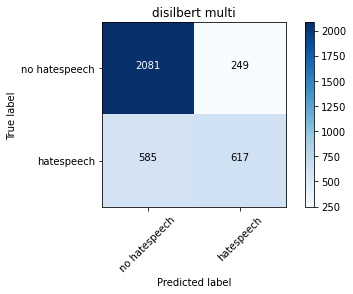

In [34]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='disilbert multi')